# BLIP-VQA Inference Playground

Compare predictions between base BLIP model and fine-tuned model on VizWiz dataset.

## Setup and Imports

In [2]:
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import BlipForQuestionAnswering, AutoProcessor

c:\Users\nemos\anaconda3\envs\questionAnswering\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading base model...")
base_model = BlipForQuestionAnswering.from_pretrained('Salesforce/blip-vqa-base')
base_processor = AutoProcessor.from_pretrained('Salesforce/blip-vqa-base')
base_model.to(device)
base_model.eval()

print("Loading trained model...")
trained_model = BlipForQuestionAnswering.from_pretrained('MohammadAlameenArtan/BLIP_Model_VizWiz')
trained_processor = AutoProcessor.from_pretrained('MohammadAlameenArtan/BLIP_Model_VizWiz')
trained_model.to(device)
trained_model.eval()

print("Models loaded successfully!")

Using device: cpu
Loading base model...


c:\Users\nemos\anaconda3\envs\questionAnswering\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nemos\.cache\huggingface\hub\models--Salesforce--blip-vqa-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to

Loading trained model...


c:\Users\nemos\anaconda3\envs\questionAnswering\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nemos\.cache\huggingface\hub\models--MohammadAlameenArtan--BLIP_Model_VizWiz. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. F

Models loaded successfully!


## Helper Functions

In [4]:
def load_image(image_source):
    if image_source.startswith('http://') or image_source.startswith('https://'):
        response = requests.get(image_source)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_source).convert('RGB')
    return image


def predict_answer(image, question, model, processor):
    inputs = processor(images=image, text=question, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.generate(**inputs)
    
    answer = processor.decode(outputs[0], skip_special_tokens=True)
    return answer


def visualize_comparison(image, question, base_answer, trained_answer, correct_answer=None):
    fig, ax = plt.subplots(figsize=(10, 12))
    
    ax.imshow(image)
    ax.axis('off')
    
    if correct_answer:
        color_base = 'green' if base_answer.lower() == correct_answer.lower() else 'red'
        color_trained = 'green' if trained_answer.lower() == correct_answer.lower() else 'red'
    else:
        color_base = 'blue'
        color_trained = 'orange'
    
    plt.text(0.5, -0.08, f"Question: {question}", 
             fontsize=14, ha='center', weight='bold', transform=ax.transAxes)
    plt.text(0.5, -0.13, f"Base Model: {base_answer}", 
             fontsize=13, color=color_base, ha='center', transform=ax.transAxes)
    plt.text(0.5, -0.18, f"Trained Model: {trained_answer}", 
             fontsize=13, color=color_trained, ha='center', transform=ax.transAxes)
    
    if correct_answer:
        plt.text(0.5, -0.23, f"Correct Answer: {correct_answer}", 
                 fontsize=13, ha='center', weight='bold', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()


def compare_models(image_source, question, correct_answer=None):
    print(f"Loading image from: {image_source}")
    image = load_image(image_source)
    
    print(f"\nQuestion: {question}")
    print("\nGenerating answers...")
    
    base_answer = predict_answer(image, question, base_model, base_processor)
    trained_answer = predict_answer(image, question, trained_model, trained_processor)
    
    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(f"Base Model Answer:    {base_answer}")
    print(f"Trained Model Answer: {trained_answer}")
    
    if correct_answer:
        print(f"Correct Answer:       {correct_answer}")
        print(f"\nBase Model Correct:    {base_answer.lower() == correct_answer.lower()}")
        print(f"Trained Model Correct: {trained_answer.lower() == correct_answer.lower()}")
    
    print("="*60)
    
    visualize_comparison(image, question, base_answer, trained_answer, correct_answer)
    
    return base_answer, trained_answer

## Example 1: Car and Planes

From the original notebook example.

Loading image from: https://i.pinimg.com/564x/ca/92/40/ca9240d151ac9f6a65ec5514c860c28f.jpg

Question: what vehicles are in the picture

Generating answers...

RESULTS
Base Model Answer:    jeep and jeep
Trained Model Answer: jeep jeep
Correct Answer:       car and two planes

Base Model Correct:    False
Trained Model Correct: False


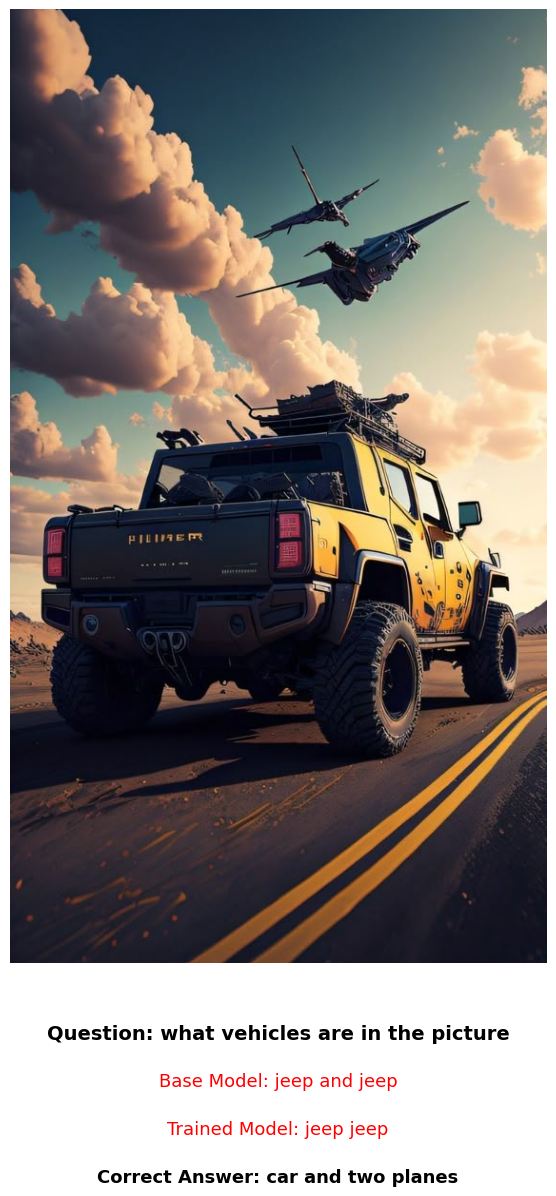

In [5]:
image_url = 'https://i.pinimg.com/564x/ca/92/40/ca9240d151ac9f6a65ec5514c860c28f.jpg'
question = 'what vehicles are in the picture'
correct_answer = 'car and two planes'

base_ans, trained_ans = compare_models(image_url, question, correct_answer)

## Example 2: Your Custom Test

Try your own image and question!

In [ ]:
image_source = 'https://example.com/your-image.jpg'
question = 'what is in the image?'
correct_answer = None

base_ans, trained_ans = compare_models(image_source, question, correct_answer)

## Example 3: Local Image

Test with a local image file.

In [ ]:
image_path = './path/to/your/image.jpg'
question = 'describe this image'
correct_answer = None

base_ans, trained_ans = compare_models(image_path, question, correct_answer)

## Batch Testing

Test multiple images at once.

In [ ]:
test_cases = [
    {
        'image': 'https://example.com/image1.jpg',
        'question': 'what color is the car?',
        'answer': 'red'
    },
    {
        'image': 'https://example.com/image2.jpg',
        'question': 'how many people are there?',
        'answer': '3'
    },
]

results = []
for i, test in enumerate(test_cases):
    print(f"\n{'='*60}")
    print(f"Test Case {i+1}/{len(test_cases)}")
    print(f"{'='*60}")
    
    base_ans, trained_ans = compare_models(
        test['image'], 
        test['question'], 
        test['answer']
    )
    
    results.append({
        'question': test['question'],
        'base': base_ans,
        'trained': trained_ans,
        'correct': test['answer']
    })

## Interactive Playground

Run this cell and modify the variables to test different scenarios!

In [ ]:
IMAGE_URL = 'https://i.pinimg.com/564x/ca/92/40/ca9240d151ac9f6a65ec5514c860c28f.jpg'
QUESTION = 'what vehicles are in the picture'
CORRECT_ANSWER = 'car and two planes'

compare_models(IMAGE_URL, QUESTION, CORRECT_ANSWER)

## Summary Statistics

If you ran batch testing, see overall performance.

In [ ]:
if 'results' in locals():
    base_correct = sum(1 for r in results if r['base'].lower() == r['correct'].lower())
    trained_correct = sum(1 for r in results if r['trained'].lower() == r['correct'].lower())
    total = len(results)
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total test cases: {total}")
    print(f"\nBase Model:")
    print(f"  Correct: {base_correct}/{total} ({100*base_correct/total:.1f}%)")
    print(f"\nTrained Model:")
    print(f"  Correct: {trained_correct}/{total} ({100*trained_correct/total:.1f}%)")
    print(f"\nImprovement: {trained_correct - base_correct} questions")
    print("="*60)
else:
    print("No batch testing results available. Run the batch testing cell first!")